In [1]:
from groo.groo import get_root
root_dir = get_root(".root_dir_covid")

import os

print(root_dir)
import sys
sys.path.append(os.path.join(root_dir, "covid-fear", "scripts"))


import numpy as np
import pandas as pd
from cov_functions import *
import seaborn as sns
import pingouin as pg
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import itertools
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression as lm
from scipy.stats import zscore
import bambi as bmb
import arviz as az
import bammm.bammm as mm
import matplotlib.pyplot as plt
import networkx as nx
import json
from itertools import product, combinations
import statsmodels.formula.api as smf



# load main dataset
df = pd.read_csv(os.path.join(root_dir, "data", "full_dataset_only_complete_based_on_sess_avg.csv"))
df["cases"] = df["cases14_std_unsmooth"]
df["deaths"] = df["deaths14_std_unsmooth"]
corr_type = "spearman"
flag = "short"

/data/drive/postdoc/Project4_covid


In [2]:
no_trait_factors = 4
if no_trait_factors == 6:
        trait_factor_names = ["TF1_Self_Consciousness", "TF2_Positive", "TF3_Catastrophizing",  "TF4_Physiological_Anx",  "TF5_Depression",  "TF6_Cognitive_Anx"]
elif no_trait_factors==5:
    trait_factor_names = ["TF1_Worry", "TF2_Self_Worth", "TF3_Catastrophizing",  "TF4_Anxiety",  "TF5_Depression"]    
elif no_trait_factors==3:
        trait_factor_names = ["TF3_NegativeAffect", "TF2_PhysiolAnx", "TF1_CognAnxDepr"]
elif no_trait_factors==4:
        trait_factor_names = ["TF3_NegativeAffect", "TF2_PhysiolAnx", "TF1_CognAnxDepr","stai_ta"]
        #trait_factor_names_short = ["TF3", "TF2", "TF1","TA"]
        trait_factor_names_short = ["TF3", "TF2", "TF1"]
elif no_trait_factors==99:
    trait_factor_names = ["stai_ta", "sticsa_ta", "cat", "bdi"] 


mapdict = {'TF3_NegativeAffect': 'TF3',
           'TF2_PhysiolAnx': 'TF2', 
           'TF1_CognAnxDepr': 'TF1',
           'stai_ta': "TA",
           'covid_worry': 'Worry', 
           'prob_est': 'Probest',
           'q7_worry_econ_impact': 'EconWorr',
           'q6_apply_soc_dist': 'SocialDist',
           'q6_risk_group': 'RiskGr',
           'avoid_beh': 'AvoidBeh',
           'avoid_anx': 'AvoidAnx',
           'q6_media_freq_num': 'InforSeek',
           'q6_media_valence': 'MediaVal',
           'q7_period_rel_danger': 'DangerSate',
           'deaths': 'Deaths',
           'cases': 'Cases',
           'worryhealth': 'HealthWorry',
           'q6_work_home': "WorkHome",
           'sticsa_som_sa_currsess': "StateSomAnx",
       #    "q6_close_person_infdied": "ClosePDied",
            "covid_thoughts": "CovThoughts", 
            "memory_worry_infected_baselined": "MemWorry", 
            "memory_prob_infected_baselined": "MemProb", 

            #"affheallth-econ-worry": "Health>Econ \n worry", 
            #"covid_cases_est_diff": "Estimate of \n covid cases"
           }


vars = ["Worry", "Probest", 
 "AvoidBeh", "AvoidAnx", "InforSeek", 
 "DangerSate", "Deaths","Cases"]
if flag =="short": 
        vars = ["AvoidBeh", "InforSeek", 
        "DangerSate", "Deaths","Cases"]

#vars = ["F1_exposure_anxiety","F2_covid_worry", "F3_infection_probability",  
#                "F4_mixed_IS_closep", "F5_danger_perception", "F6_econ_worry", 
#                "F7_skepticism", "F8_time_end_estimates", "F9_avoidance",  "Deaths","Cases"]


df=df.rename(columns=mapdict)
dfall = df.copy()

df.loc[:,vars] = df.loc[:,vars].apply(zscore, nan_policy='omit')
df = df.loc[:,vars+["PROLIFICID","session"]]
#tdf = df.pivot(columns="session", index="PROLIFICID", values=vars+vars_factors)

id_df = dfall.loc[:,["PROLIFICID","TF3", "TF2", "TF1", "TA"]].groupby(by=["PROLIFICID"]).mean()

In [3]:
df

AvoidBeh  InforSeek  DangerSate    Deaths     Cases        PROLIFICID  \
0     1.268500   1.159173    0.798617  2.930890 -0.332740  01S0stEpc3rU6YxK   
1     1.268500   1.159173   -1.026494  1.045315 -0.333964  01S0stEpc3rU6YxK   
2     1.268500   1.159173   -1.026494  0.016820 -0.507775  01S0stEpc3rU6YxK   
3     0.813694  -0.365269   -1.026494 -0.411720 -0.624058  01S0stEpc3rU6YxK   
4     0.131484  -1.127490   -1.026494 -0.497428 -0.660779  01S0stEpc3rU6YxK   
...        ...        ...         ...       ...       ...               ...   
5820  0.813694   1.159173    0.798617 -0.529675  1.445619  ztPVSoIVH3QKpGeQ   
5821  0.586290   1.159173    1.406987 -0.438647  2.278743  ztPVSoIVH3QKpGeQ   
5822  0.813694   1.159173    1.406987 -0.029020  2.345393  ztPVSoIVH3QKpGeQ   
5823 -0.323322   0.396952    0.190246  0.198550  0.990832  ztPVSoIVH3QKpGeQ   
5824  0.586290   1.159173    1.406987  1.108831  0.820287  ztPVSoIVH3QKpGeQ   

      session  
0           1  
1           2  
2           3  
3           4  
4           5  
...       ...  
5820       16  
5821       17  
5822       18  
5823       19  
5824       20  

[5825 rows x 7 columns]

### Prepare data forwithin-sub analyses

In [4]:
win=2
def realign_win(x, win):
    nsess = 20
    x=x.reset_index(drop=True)
    y = np.zeros(shape=(nsess-win,win+1))*np.nan
    if x.shape[0] is 20:
        for w in range(win+1):
            y[:,w]= x["value"].iloc[w:nsess-win+w]
    v = x["variable"][0]
    cols = [v+"_lag"+str(w) for w in range(win, -1, -1)]
    return pd.DataFrame(y,columns=cols)

        
ttf = df.loc[:,vars+["session", "PROLIFICID"]].melt(id_vars=["PROLIFICID", "session"]).groupby(by=["PROLIFICID", "variable"]).apply(realign_win, win)
ttf = ttf.reset_index()#.pivot(index="PROLIFICID", columns=["lag2", "lag1", "lag0"])

### get within-sub regression coefficients

In [5]:
import pingouin as pg
combs = pd.DataFrame(list(product(vars, vars)), columns=['dv', 'iv'])
idx = np.array(combs["dv"] != combs["iv"])
combs = combs.loc[idx]


# This just runs lag 1 partial correlations controlling for autocorrelation in dependent variable 
def get_within_reg_coefs(ttf, combs):
    odf = pd.DataFrame()
    for iv, dv in zip(combs.iv, combs.dv): 
        qdf = pd.concat([ttf.loc[ttf["variable"]==dv,[dv+"_lag"+str(i) for i in range(win+1)]].reset_index(), ttf.loc[ttf["variable"]==iv,[iv+"_lag"+str(i) for i in range(win+1)]].reset_index()], axis=1).dropna()
        old_names = [dv+"_lag"+str(i) for i in range(1,win+1)]+[iv+"_lag"+str(i) for i in range(win+1)]
        new_names = ["dv_lag"+str(i) for i in range(1,win+1)]+["iv_lag"+str(i) for i in range(win+1)]
        rename_dict = dict([(o, n)  for o,n in zip(old_names, new_names)])
        if qdf.shape[0] != 0:
            eq = mm.generate_equation(dv+"_lag0", [dv+"_lag"+str(i) for i in range(1,win+1)]+[iv+"_lag"+str(i) for i in range(win+1)]  , [""], "reducedrank") 
            mod = smf.ols(eq, qdf)          
            res = mod.fit()
            #cdf = res.conf_int(alpha=0.05)
            #cdf.columns = ["CI5", "CI95"]
            cdf = res.params
            cdf["dv"] = dv 
            cdf["iv"] = iv 
            cdf = pd.DataFrame(cdf.rename(index=rename_dict)).T
            
        else: 
            cdf = pd.DataFrame(np.zeros((1,7))*np.nan, columns=["dv_lag"+str(i) for i in range(1,win+1)]+["iv_lag"+str(i) for i in range(win+1)]+["dv", "iv"])
        #c = pg.partial_corr(qdf, x=iv+"_lag1", y=dv+"_lag0", covar=dv+"_lag1", method=corr_type)
        #r = np.array(c["r"]) 
        odf = pd.concat([odf, cdf], axis=0)
    return(odf)

ld=1
if ld == 0:
    tdf = ttf.groupby(by="PROLIFICID").apply(get_within_reg_coefs, combs)
    tdf = tdf.reset_index() 
    # only with dv(t) ~ dv(t-1) + iv(t-1)
    tdf.to_csv(os.path.join(root_dir, "output", "working_data", "lag"+str(win)+"_withinsub_regressions.csv"))
else: 
    #tdf = pd.read_csv(os.path.join(root_dir, "output", "working_data", "lag"+str(win)+"_withinsub_regressions.csv"))
    tdf = pd.read_csv(os.path.join(root_dir, "output", "working_data", "lag"+str(win)+"_withinsub_regressions_standard_regressors.csv"))

In [6]:
tdf

Unnamed: 0        PROLIFICID  level_1  Intercept   dv_lag1   dv_lag2  \
0               0  01S0stEpc3rU6YxK        0   0.337446  0.404462  0.069886   
1               1  01S0stEpc3rU6YxK        0  -0.253903  0.482584  0.362665   
2               2  01S0stEpc3rU6YxK        0  -0.376187  0.494155  0.123183   
3               3  01S0stEpc3rU6YxK        0  -0.375158  0.531714  0.125739   
4               4  01S0stEpc3rU6YxK        0  -0.459297  0.501864  0.073321   
...           ...               ...      ...        ...       ...       ...   
16795       16795  ztPVSoIVH3QKpGeQ        0  -0.144210  1.463459 -0.623821   
16796       16796  ztPVSoIVH3QKpGeQ        0   0.021814  1.447298 -0.668900   
16797       16797  ztPVSoIVH3QKpGeQ        0  -0.467625  1.382579 -0.609300   
16798       16798  ztPVSoIVH3QKpGeQ        0  -0.174757  1.240833 -0.539904   
16799       16799  ztPVSoIVH3QKpGeQ        0   0.059049  1.348205 -0.689338   

        iv_lag0   iv_lag1   iv_lag2     dv          iv  
0      0.492236  0.713162  0.221620  Worry     Probest  
1      0.072494 -0.282196  0.135947  Worry    AvoidBeh  
2     -0.100154  0.121401 -0.008029  Worry    AvoidAnx  
3     -0.066383  0.069244 -0.044477  Worry   InforSeek  
4      0.408694 -0.591138  0.108689  Worry  DangerSate  
...         ...       ...       ...    ...         ...  
16795  0.453183 -0.312286  0.153100  Cases    AvoidBeh  
16796  0.188824 -0.637836  0.276442  Cases    AvoidAnx  
16797  0.581015 -0.227206  0.162778  Cases   InforSeek  
16798  0.273983  0.081619  0.069745  Cases  DangerSate  
16799  0.458102 -0.075940 -0.284684  Cases      Deaths  

[16800 rows x 11 columns]

### Plot averaged tendencies (without trait factors)

In [7]:
gdf = tdf.melt(id_vars=["PROLIFICID", "dv", "iv"], value_vars=["iv_lag0", "iv_lag1", "iv_lag2", "dv_lag1", "dv_lag2"], var_name="var", value_name="beta")
gdf["beta"]  = gdf["beta"].astype(float)


# filter for vars of itnerest
gdf = gdf.loc[gdf["iv"].isin(vars) & gdf["dv"].isin(vars),:]




In [8]:
bounds = gdf.groupby(by=["var", "iv", "dv"])['beta'].apply(pg.ttest, 0, paired=False).round(3).reset_index()
def extract_values(row):
    return pd.Series(row['CI95%'])

# Apply the function to create two new columns
bounds[['CI5', 'CI95']] = bounds.apply(extract_values, axis=1)


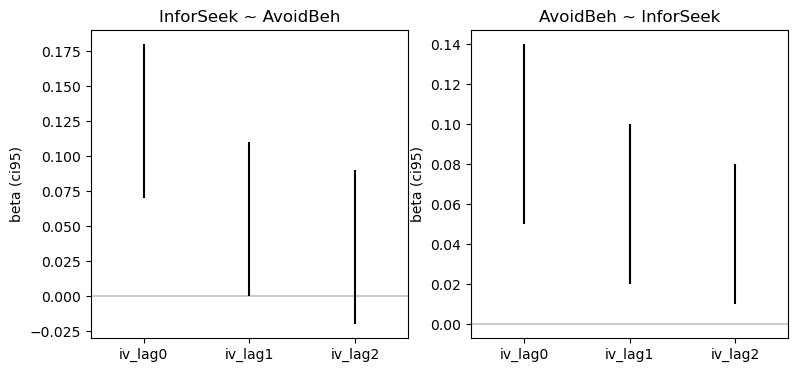

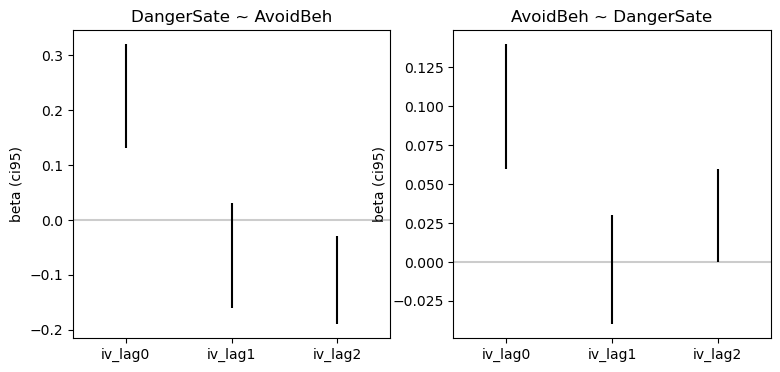

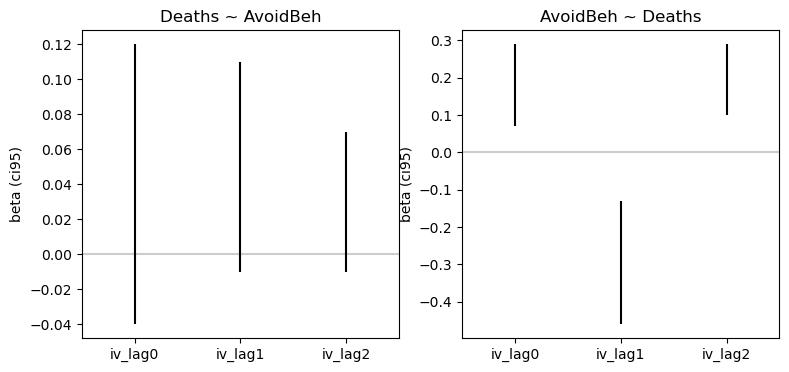

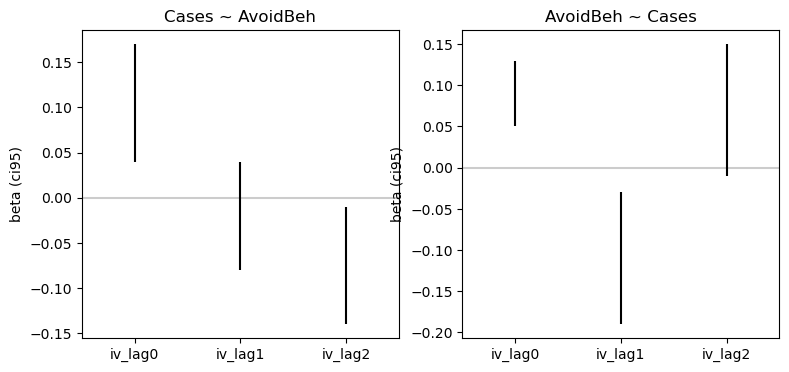

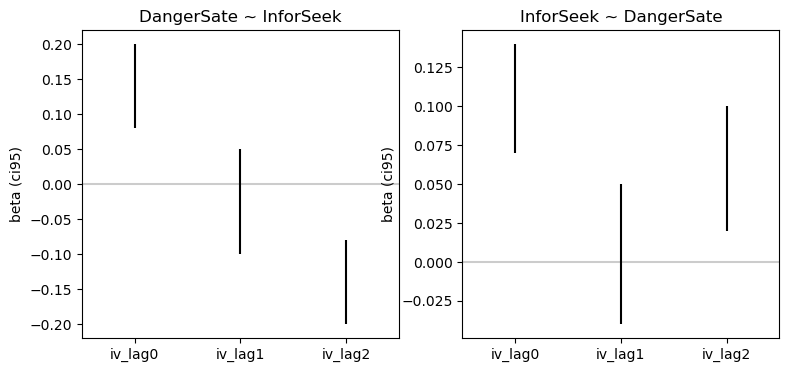

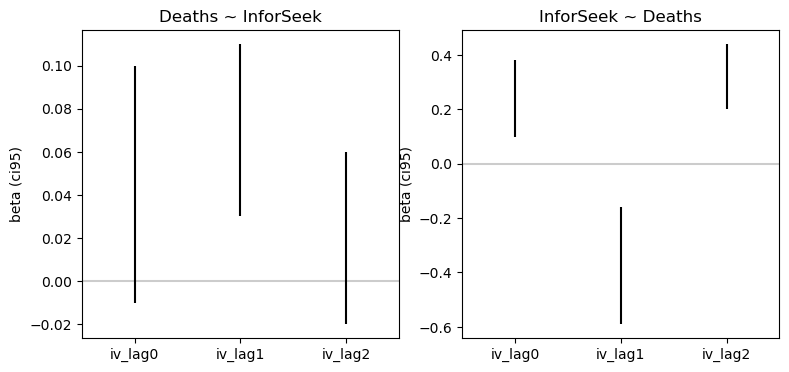

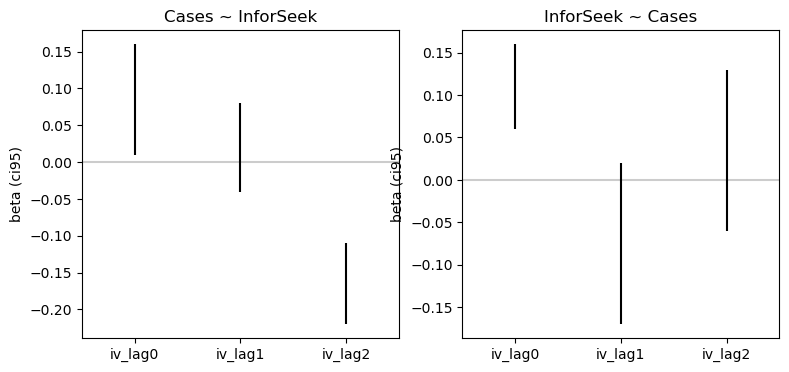

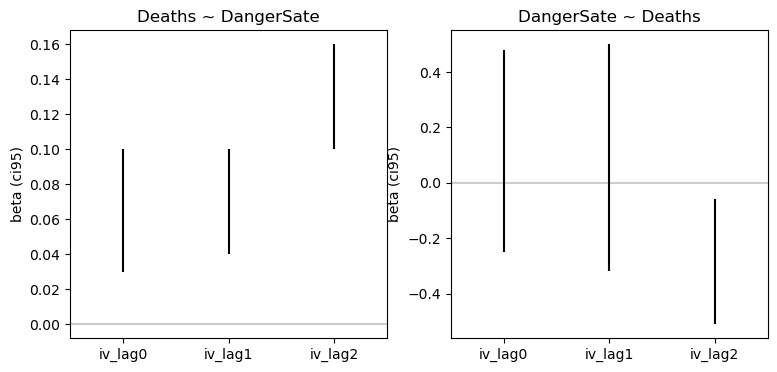

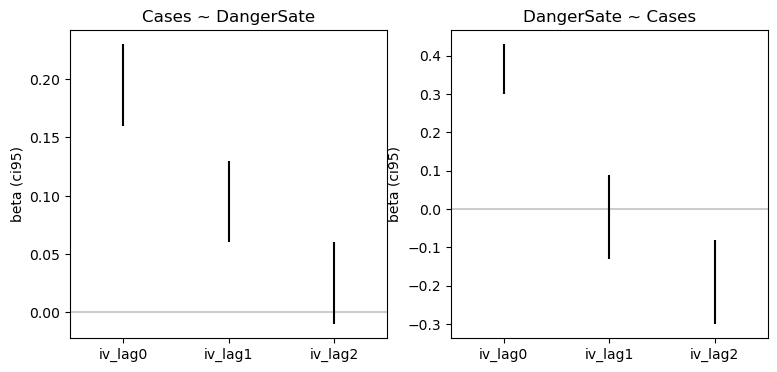

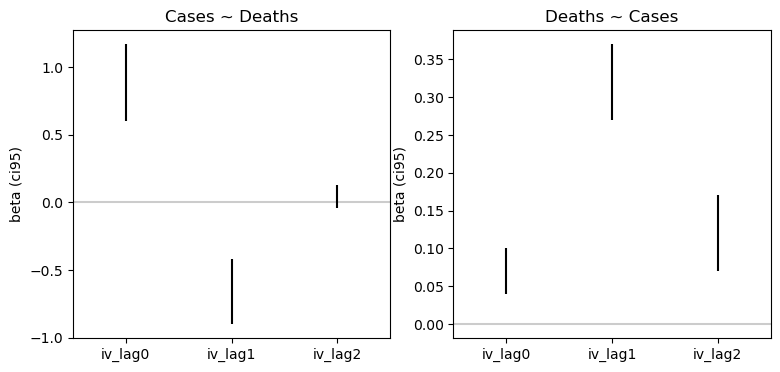

In [9]:
combs = pd.DataFrame(list(combinations(vars,2)), columns=["v1", "v2"])
#pal = ["pink", "dodgerblue", "lightseagreen"]
pal = ["black","black", "black"] # + pal + pal + pal
#fitdf.to_csv(os.path.join(root_dir, "output",  "models", "model_data", "lagmodels_window3.csv"))
for v1, v2 in zip(combs.v1, combs.v2): #zip(["Worry"], ["Probest"]): #
    #df1 = gdf.loc[(gdf["iv"]==v1) & (gdf["dv"]==v2) & gdf["var"].str.contains("iv_lag"),:]
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    #axs[0] = sns.pointplot(x="var", y= "beta",
    #                data=df1, dodge=.532, join=False, palette=pal,
    #                markers="d", scale=1, ci=None, ax=axs[0])
    lb = bounds.loc[(bounds["iv"]==v1) & (bounds["dv"]==v2) & bounds["var"].str.contains("iv_lag")].set_index("var")
    #lb = lb.loc[[x.get_text() for x in axs[0].get_xticklabels()],:].reset_index()
    #
    axs[0].vlines(np.arange(0,lb.shape[0],1), lb["CI5"], lb["CI95"], colors='black')
    axs[0].axhline(0, alpha=0.2, color='black')
    axs[0].set_title(v2+" ~ "+v1)
    axs[0].set_ylabel("beta (ci95)")
    axs[0].set_xlabel("")
    axs[0].set_xticks(np.arange(0,lb.shape[0],1))
    axs[0].set_xticklabels(lb.index)
    #axs[0].set_ylim([-0.2, 0.2])
    axs[0].set_xlim([-0.5,2.5])


    #df1 = gdf.loc[(gdf["iv"]==v2) & (gdf["dv"]==v1) & gdf["var"].str.contains("iv_lag"),:]
    #axs[1] = sns.pointplot(x="var", y= "beta",
    #                data=df1, dodge=.532, join=False, palette=pal,
    #                markers="d", scale=1, ci=None, ax=axs[1])
    lb = bounds.loc[(bounds["iv"]==v2) & (bounds["dv"]==v1) & bounds["var"].str.contains("iv_lag")].set_index("var")
    #lb = lb.loc[[x.get_text() for x in axs[1].get_xticklabels()],:].reset_index()
    #
    axs[1].vlines(np.arange(0,lb.shape[0],1), lb["CI5"], lb["CI95"], colors='black')
    axs[1].axhline(0, alpha=0.2, color='black')
    axs[1].set_title(v1+" ~ "+v2)
    axs[1].set_ylabel("beta (ci95)")
    axs[1].set_xlabel("")
    axs[1].set_xlim([-0.5,2.5])
    #axs[1].set_ylim([-0.1,0.5])
    axs[1].set_xticks(np.arange(0,lb.shape[0],1))
    axs[1].set_xticklabels(lb.index)

    #label = df1.groupby(by=["var", "iv", "dv", "label"])["sample"].mean().loc[[x.get_text() for x in axs[0].get_xticklabels()],:].reset_index()["label"]
    #axs[0].set_xticklabels(label, rotation = -30, ha='left')



In [10]:
bounds = gdf.groupby(by=["var", "iv", "dv"])['beta'].agg(['mean', 'sem']).reset_index()
bounds.head(15)

var          iv          dv      mean       sem
0   dv_lag1    AvoidBeh       Cases  1.117829  0.028016
1   dv_lag1    AvoidBeh  DangerSate  0.330354  0.022938
2   dv_lag1    AvoidBeh      Deaths  1.216242  0.040919
3   dv_lag1    AvoidBeh   InforSeek  0.264475  0.022606
4   dv_lag1       Cases    AvoidBeh  0.099103  0.020904
5   dv_lag1       Cases  DangerSate  0.187493  0.026242
6   dv_lag1       Cases      Deaths  0.434774  0.032060
7   dv_lag1       Cases   InforSeek  0.223041  0.023702
8   dv_lag1  DangerSate    AvoidBeh  0.138607  0.021851
9   dv_lag1  DangerSate       Cases  1.007838  0.029993
10  dv_lag1  DangerSate      Deaths  1.180670  0.039128
11  dv_lag1  DangerSate   InforSeek  0.240621  0.023871
12  dv_lag1      Deaths    AvoidBeh  0.021260  0.023101
13  dv_lag1      Deaths       Cases  0.915594  0.061529
14  dv_lag1      Deaths  DangerSate  0.226160  0.024205

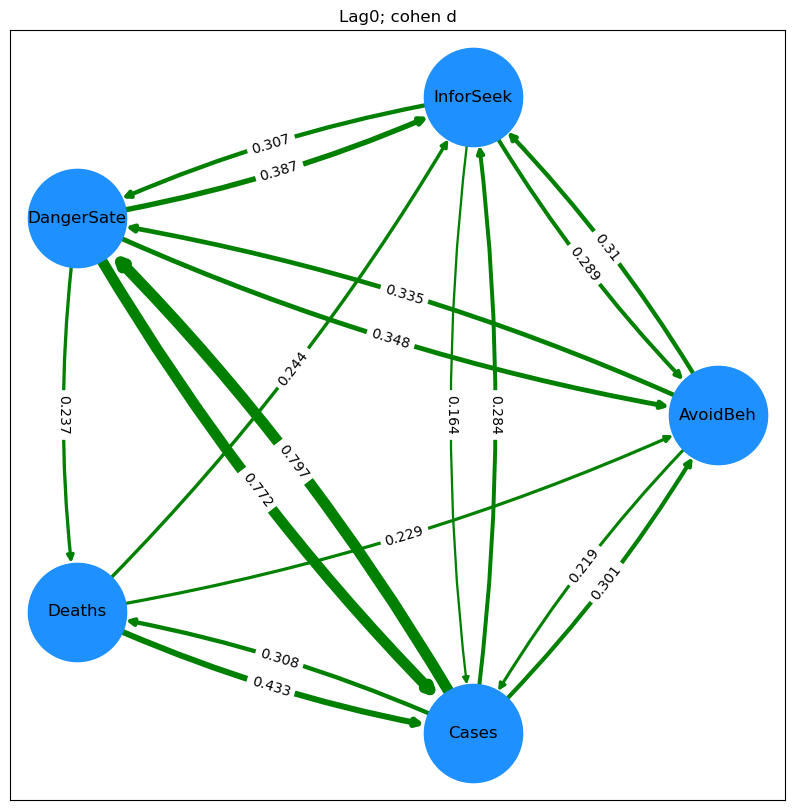

In [11]:
# get data
v2s = "cohen-d"
def extract_values(row):
    return pd.Series(row['CI95%'])

# this one gets the stats
bounds = gdf.groupby(by=["var", "iv", "dv"])['beta'].apply(pg.ttest, 0, paired=False).round(3).reset_index()
bounds[['CI5', 'CI95']] = bounds.apply(extract_values, axis=1)
bounds["betaest"] = bounds.loc[:,['CI5', 'CI95']].mean(axis=1)

# this one just gets the mean betas
#bounds = gdf.groupby(by=["var", "iv", "dv"])['beta'].agg(['mean', 'sem']).reset_index()
#bounds["CI5"] = bounds["mean"] - bounds["sem"]
#bounds["CI95"] = bounds["mean"] + bounds["sem"]

# filter for same session and only "significant" 
bdf = bounds.loc[bounds["var"]=="iv_lag0",:]
bdf["sig"]  = ["ns" if l<0<u else "s" for l,u in zip(bdf["CI5"], bdf["CI95"])]
bdf = bdf.loc[bdf["sig"]=="s",:]
combs = dict([((iv, dv), "x") for dv, iv in zip(bdf["dv"], bdf["iv"])])
edge_colors = ["green" if x>=0 else "red" for x in bdf[v2s]]

import matplotlib
import matplotlib.cm as cm

# Prepare bodes, edges and layouts 
G = nx.DiGraph()
G.add_nodes_from(vars)
G.add_edges_from(combs)
edge_labels = dict([((iv, dv), round(float(bdf.loc[(bdf["iv"]==iv) & (bdf["dv"]==dv),v2s]),3)) for iv, dv in zip(bdf["iv"],bdf["dv"])])
edge_widths = np.array([round(float(bdf.loc[(bdf["iv"]==iv) & (bdf["dv"]==dv),v2s]),3) for iv, dv in zip(bdf["iv"],bdf["dv"])])
#norm = matplotlib.colors.Normalize(vmin=-1, vmax=1, clip=True)
#mapper = cm.ScalarMappable(norm=norm, cmap=cm.Spectral)

nodesize = 5000
arc_rad = 0.07
pos=nx.circular_layout(G)
fig, ax = plt.subplots(1,1,figsize=(10,10))
nx.draw_networkx_nodes(G, pos, ax=ax, node_shape="o", node_size=nodesize, node_color='dodgerblue')
nx.draw_networkx_labels(G, pos, ax=ax)

nx.draw_networkx_edges(G, pos, ax=ax, width=edge_widths*10, edgelist=combs, edge_color=edge_colors, connectionstyle=f'arc3, rad = {arc_rad}', arrows=True, arrowsize=10, node_size=nodesize)
#fig.savefig("2.png", bbox_inches='tight',pad_inches=0)

my_draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels, ax=ax,  rad=arc_rad)
ax.set_title("Lag0; cohen d")
plt.show()

### 

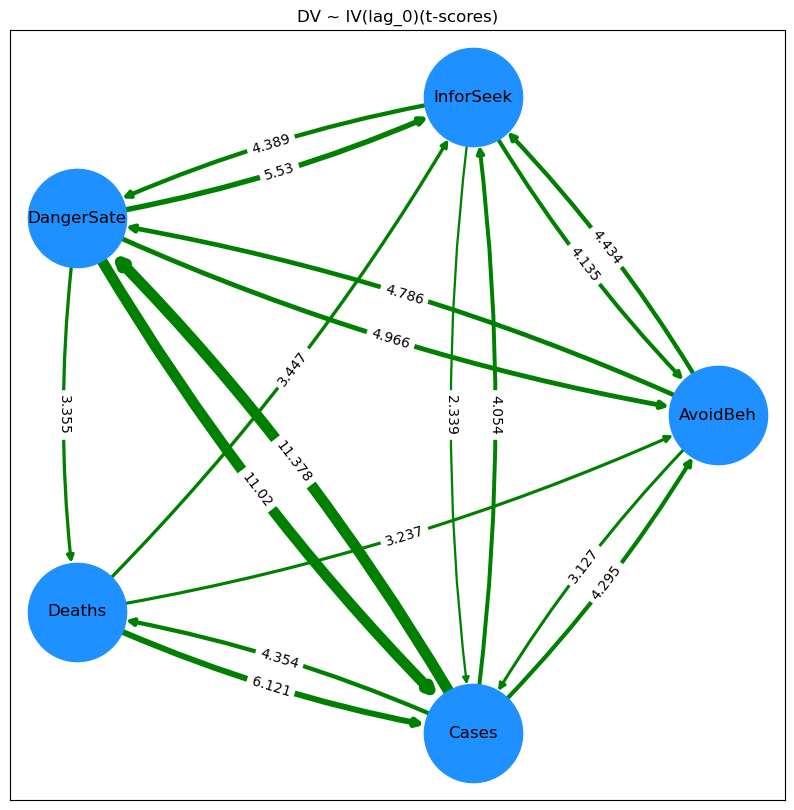

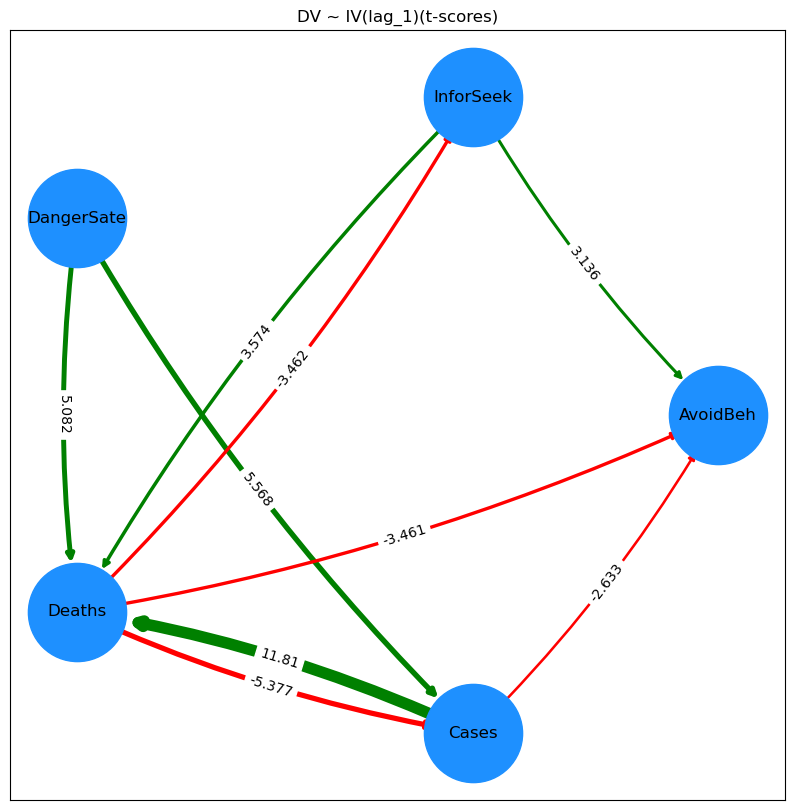

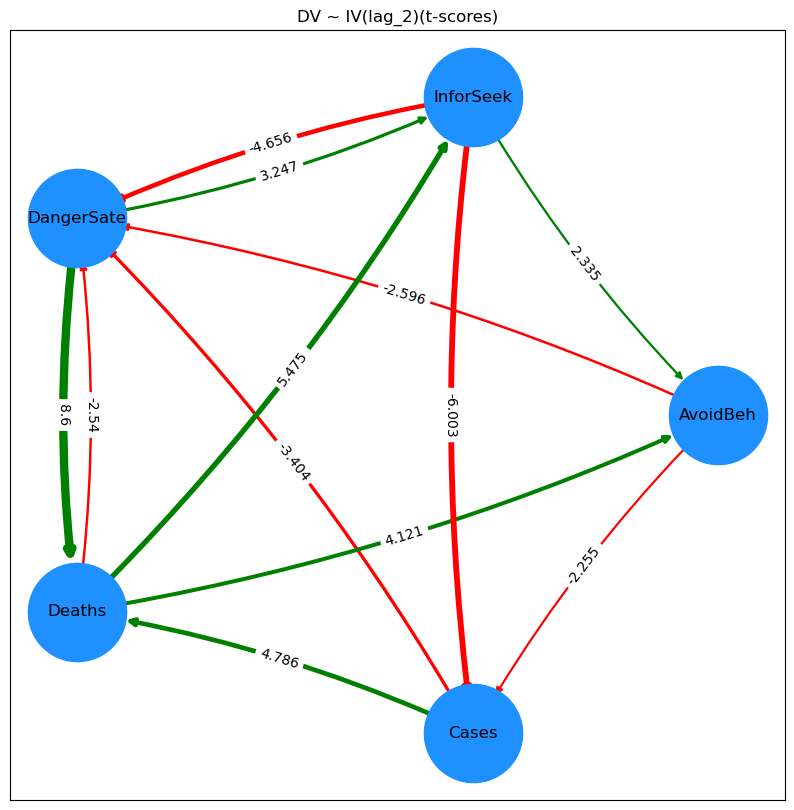

In [12]:
conds = {"varname":[ "iv_lag0", "iv_lag1", "iv_lag2"], 
         "label":["DV ~ IV(lag_0)", "DV ~ IV(lag_1)", "DV ~ IV(lag_2)"]}

v2s = "T"

for v, lbl in zip(conds["varname"], conds["label"]):
    # get data
    bounds = gdf.loc[gdf["var"]==v,:].groupby(by=["iv", "dv"])['beta'].apply(pg.ttest, 0, paired=False).reset_index()
    ffdf = pd.DataFrame(pg.multicomp(bounds["p-val"], method="fdr_bh")).T
    ffdf.columns =["H", "corr_p"]
    bounds = pd.concat([bounds,ffdf ], axis=1)
    bounds[['CI5', 'CI95']] = bounds.apply(extract_values, axis=1)
    bounds["betaest"] = bounds.loc[:,['CI5', 'CI95']].mean(axis=1)
    
    # filter for same session and only "significant" 
    #bdf = bounds.loc[bounds["var"]==v,:]
    bdf = bounds
    bdf["sig"]  = ["ns" if p>=0.05 else "s" for p in bdf["corr_p"]]
    bdf = bdf.loc[bdf["sig"]=="s",:]
    combs = dict([((iv, dv), "x") for dv, iv in zip(bdf["dv"], bdf["iv"])])
    edge_colors = ["green" if x>=0 else "red" for x in bdf[v2s]]

    import matplotlib
    import matplotlib.cm as cm

    # Prepare bodes, edges and layouts 
    G = nx.DiGraph()
    G.add_nodes_from(vars)
    G.add_edges_from(combs)
    edge_labels = dict([((iv, dv), round(float(bdf.loc[(bdf["iv"]==iv) & (bdf["dv"]==dv),v2s]),3)) for iv, dv in zip(bdf["iv"],bdf["dv"])])
    edge_widths = np.array([round(float(bdf.loc[(bdf["iv"]==iv) & (bdf["dv"]==dv),v2s]),3) for iv, dv in zip(bdf["iv"],bdf["dv"])])
    #norm = matplotlib.colors.Normalize(vmin=-1, vmax=1, clip=True)
    #mapper = cm.ScalarMappable(norm=norm, cmap=cm.Spectral)

    nodesize = 5000
    arc_rad = 0.07
    pos=nx.circular_layout(G)
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    nx.draw_networkx_nodes(G, pos, ax=ax, node_shape="o", node_size=nodesize, node_color='dodgerblue')
    nx.draw_networkx_labels(G, pos, ax=ax)

    nx.draw_networkx_edges(G, pos, ax=ax, width=edge_widths*0.7, edgelist=combs, edge_color=edge_colors, connectionstyle=f'arc3, rad = {arc_rad}', arrows=True, arrowsize=10, node_size=nodesize)
    #fig.savefig("2.png", bbox_inches='tight',pad_inches=0)

    my_draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels, ax=ax,  rad=arc_rad)
    ax.set_title(lbl + "(t-scores)")
    plt.show()

### Correlations 

In [17]:
gdf = gdf.set_index("PROLIFICID").join(id_df)

dv          iv      var      beta       TF3  \
PROLIFICID                                                             
01S0stEpc3rU6YxK   AvoidBeh   InforSeek  iv_lag0  0.216598 -0.045855   
01S0stEpc3rU6YxK   AvoidBeh  DangerSate  iv_lag0  0.647611 -0.045855   
01S0stEpc3rU6YxK   AvoidBeh      Deaths  iv_lag0  0.384599 -0.045855   
01S0stEpc3rU6YxK   AvoidBeh       Cases  iv_lag0  0.195444 -0.045855   
01S0stEpc3rU6YxK  InforSeek    AvoidBeh  iv_lag0  0.186273 -0.045855   
...                     ...         ...      ...       ...       ...   
ztPVSoIVH3QKpGeQ     Deaths       Cases  dv_lag2  0.372175 -1.471485   
ztPVSoIVH3QKpGeQ      Cases    AvoidBeh  dv_lag2 -0.623821 -1.471485   
ztPVSoIVH3QKpGeQ      Cases   InforSeek  dv_lag2 -0.609300 -1.471485   
ztPVSoIVH3QKpGeQ      Cases  DangerSate  dv_lag2 -0.539904 -1.471485   
ztPVSoIVH3QKpGeQ      Cases      Deaths  dv_lag2 -0.689338 -1.471485   

                       TF2       TF1         TA  
PROLIFICID                                       
01S0stEpc3rU6YxK -0.573207  0.000099  48.666667  
01S0stEpc3rU6YxK -0.573207  0.000099  48.666667  
01S0stEpc3rU6YxK -0.573207  0.000099  48.666667  
01S0stEpc3rU6YxK -0.573207  0.000099  48.666667  
01S0stEpc3rU6YxK -0.573207  0.000099  48.666667  
...                    ...       ...        ...  
ztPVSoIVH3QKpGeQ  0.071957 -0.726433  31.333333  
ztPVSoIVH3QKpGeQ  0.071957 -0.726433  31.333333  
ztPVSoIVH3QKpGeQ  0.071957 -0.726433  31.333333  
ztPVSoIVH3QKpGeQ  0.071957 -0.726433  31.333333  
ztPVSoIVH3QKpGeQ  0.071957 -0.726433  31.333333  

[20240 rows x 8 columns]

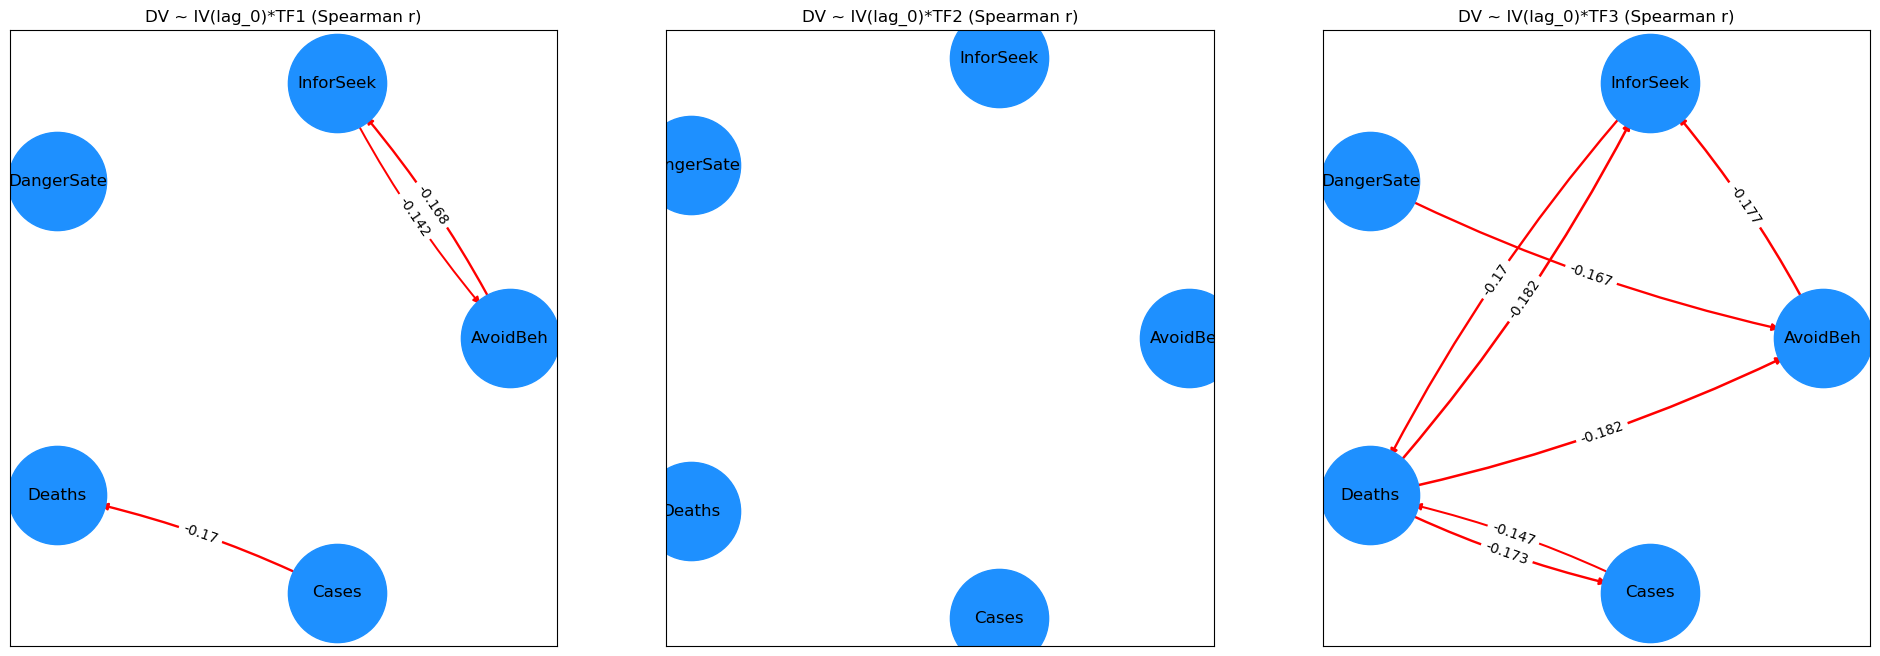

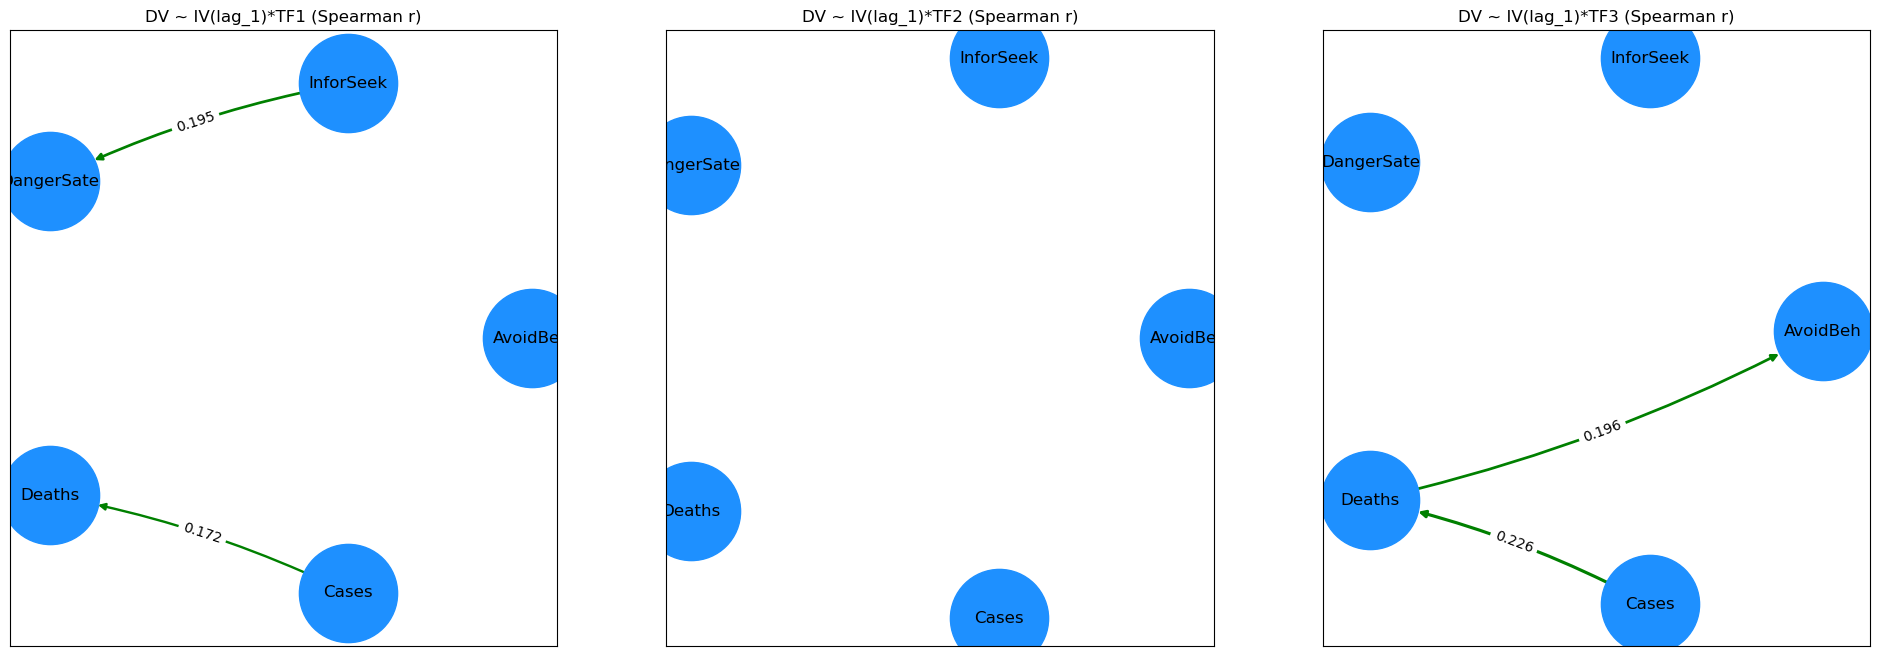

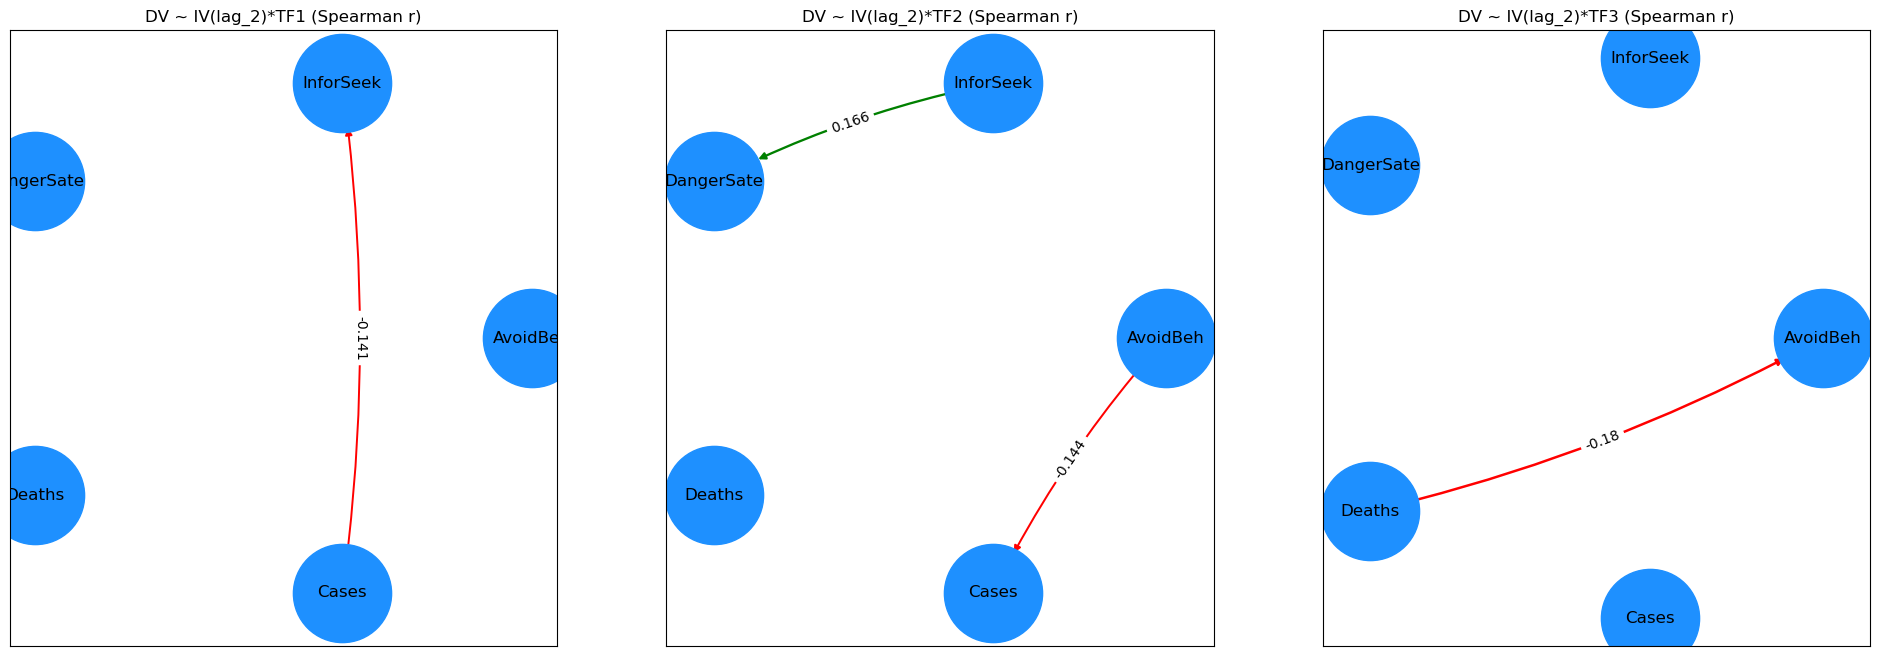

In [18]:
import matplotlib
import matplotlib.cm as cm

def runcorr(df, columns, method): 
    tdf = pg.corr(df[columns[0]], df[columns[1]], method=method)
    tdf["trait"] = columns[1]
    return tdf

conds = {"varname":[ "iv_lag0", "iv_lag1", "iv_lag2"], 
         "label":["DV ~ IV(lag_0)", "DV ~ IV(lag_1)", "DV ~ IV(lag_2)"]}
v2s = "r"

for v, lbl in zip(conds["varname"], conds["label"]):
    fig, ax = plt.subplots(1,3,figsize=(24,8))
    for tidx, tt in enumerate(["TF1", "TF2", "TF3"]):
        
        axx=ax[tidx]
        bounds = gdf.loc[gdf["var"]==v,:].groupby(by=["iv", "dv"])['beta', tt].apply(runcorr, columns =['beta', tt], method="spearman").reset_index() 
        ffdf = pd.DataFrame(pg.multicomp(bounds["p-val"], method="fdr_bh")).T
        ffdf.columns =["H", "corr_p"]
        bounds = pd.concat([bounds,ffdf ], axis=1)
        #bounds[['CI5', 'CI95']] = bounds.apply(extract_values, axis=1)

        bdf = bounds
        #bdf["sig"]  = ["ns" if p>=0.05 else "s" for p in bdf["corr_p"]]
        bdf["sig"]  = ["ns" if p>=0.05 else "s" for p in bdf["p-val"]]
        bdf = bdf.loc[bdf["sig"]=="s",:]
        combs = dict([((iv, dv), "x") for dv, iv in zip(bdf["dv"], bdf["iv"])])
        edge_colors = ["green" if x>=0 else "red" for x in bdf[v2s]]       

        # Prepare bodes, edges and layouts 
        G = nx.DiGraph()
        G.add_nodes_from(vars)
        G.add_edges_from(combs)
        edge_labels = dict([((iv, dv), round(float(bdf.loc[(bdf["iv"]==iv) & (bdf["dv"]==dv),v2s]),3)) for iv, dv in zip(bdf["iv"],bdf["dv"])])
        edge_widths = np.array([round(float(bdf.loc[(bdf["iv"]==iv) & (bdf["dv"]==dv),v2s]),3) for iv, dv in zip(bdf["iv"],bdf["dv"])])

        nodesize = 5000
        arc_rad = 0.07
        pos=nx.circular_layout(G)
        nx.draw_networkx_nodes(G, pos, ax=axx, node_shape="o", node_size=nodesize, node_color='dodgerblue')
        nx.draw_networkx_labels(G, pos, ax=axx)

        nx.draw_networkx_edges(G, pos, ax=axx, width=edge_widths*10, edgelist=combs, edge_color=edge_colors, connectionstyle=f'arc3, rad = {arc_rad}', arrows=True, arrowsize=10, node_size=nodesize)
        #fig.savefig("2.png", bbox_inches='tight',pad_inches=0)

        my_draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels, ax=axx,  rad=arc_rad)
        axx.set_title(lbl + "*"+tt+" (Spearman r)")
    plt.show()
        